In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [45]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import zscore
import joblib
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from lime.lime_tabular import LimeTabularExplainer
import shap

# ***Loading and EDA***

In [46]:
# Define paths and parameters
data_dir = "/kaggle/input/brain-tumor-mri-dataset/"
train_path = os.path.join(data_dir, "Training")
test_path = os.path.join(data_dir, "Testing")
img_size = (224, 224)
batch_size = 16  # Small batch size to reduce memory usage
num_classes = 4

# Load all images and labels into memory
all_images = []
all_labels = []
class_names = sorted(os.listdir(train_path))  # ['glioma', 'meningioma', 'notumor', 'pituitary']
print("Loading images...")
for class_idx, class_name in enumerate(class_names):
    train_class_path = os.path.join(train_path, class_name)
    for img_name in os.listdir(train_class_path):
        img_path = os.path.join(train_class_path, img_name)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        all_images.append(img_array)
        all_labels.append(class_idx)
    test_class_path = os.path.join(test_path, class_name)
    for img_name in os.listdir(test_class_path):
        img_path = os.path.join(test_class_path, img_name)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        all_images.append(img_array)
        all_labels.append(class_idx)

# Convert to NumPy arrays
all_images = np.array(all_images, dtype='float16')  # Shape: (7023, 224, 224, 3)
all_labels = np.array(all_labels)  # Shape: (7023,)
print(f"Loaded {all_images.shape[0]} images with shape {all_images.shape[1:]}")

Loading images...
Loaded 7023 images with shape (224, 224, 3)


Training Class Counts: {'pituitary': 1457, 'notumor': 1595, 'meningioma': 1339, 'glioma': 1321}
Testing Class Counts: {'pituitary': 300, 'notumor': 405, 'meningioma': 306, 'glioma': 300}


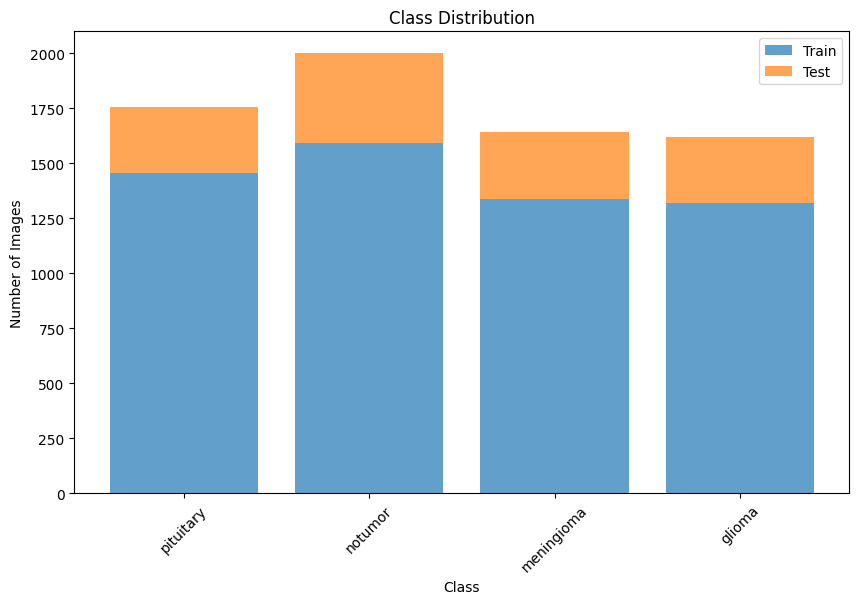

In [47]:
def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images_per_class(train_path)
test_counts = count_images_per_class(test_path)
print("Training Class Counts:", train_counts)
print("Testing Class Counts:", test_counts)

# Plot class distribution
class_df = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Train Count'])
class_df = class_df.merge(pd.DataFrame(list(test_counts.items()), columns=['Class', 'Test Count']), on='Class')
class_df['Total Count'] = class_df['Train Count'] + class_df['Test Count']
plt.figure(figsize=(10, 6))
plt.bar(class_df['Class'], class_df['Train Count'], label='Train', alpha=0.7)
plt.bar(class_df['Class'], class_df['Test Count'], bottom=class_df['Train Count'], label='Test', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [48]:
# Perform train-test split
X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

Training set: 4916 images
Validation set: 1053 images
Test set: 1054 images


In [49]:
from PIL import Image
import numpy as np

# Function to analyze image properties
def analyze_image_properties(directory, sample_size=50):
    dimensions = []
    file_sizes = []
    formats = []
    
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)[:sample_size]  # Sample to save time
            for img_name in images:
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        dimensions.append(img.size)  # (width, height)
                        formats.append(img.format)
                    file_sizes.append(os.path.getsize(img_path) / 1024)  # Size in KB
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    return dimensions, file_sizes, formats

# Analyze training set
train_dims, train_sizes, train_formats = analyze_image_properties(train_path)

Image Dimensions Summary:
             Width       Height
count   200.000000   200.000000
mean    474.390000   478.915000
std     137.149069   133.443334
min     173.000000   192.000000
25%     512.000000   512.000000
50%     512.000000   512.000000
75%     512.000000   512.000000
max    1365.000000  1365.000000

File Size Summary (KB):
count    200.000000
mean      25.343623
std       25.310409
min        4.333008
25%       16.021729
50%       21.182129
75%       26.421387
max      246.901367
dtype: float64

Image Formats:
JPEG    199
PNG       1
Name: count, dtype: int64


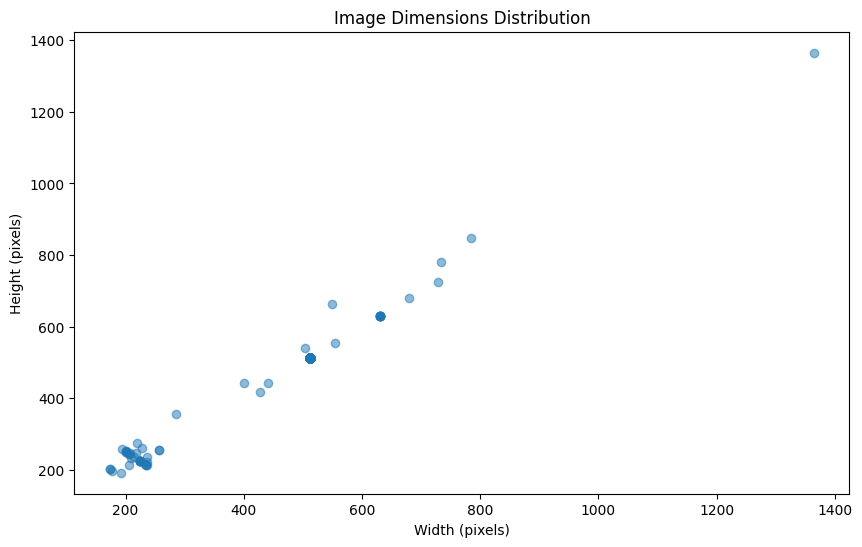

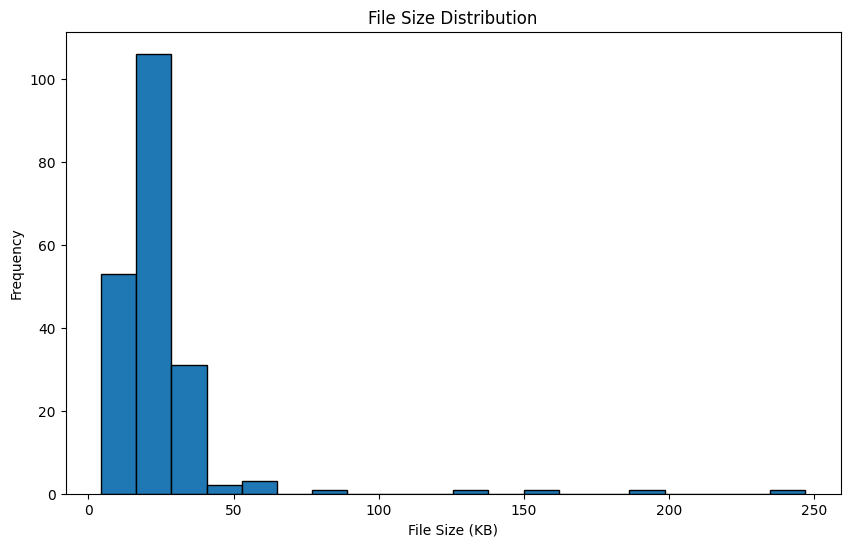

In [50]:
# Summary statistics
dims_df = pd.DataFrame(train_dims, columns=['Width', 'Height'])
print("Image Dimensions Summary:")
print(dims_df.describe())

print("\nFile Size Summary (KB):")
print(pd.Series(train_sizes).describe())

print("\nImage Formats:")
print(pd.Series(train_formats).value_counts())

# Plot dimensions
plt.figure(figsize=(10, 6))
plt.scatter(dims_df['Width'], dims_df['Height'], alpha=0.5)
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.title('Image Dimensions Distribution')
plt.show()

# Plot file sizes
plt.figure(figsize=(10, 6))
plt.hist(train_sizes, bins=20, edgecolor='black')
plt.xlabel('File Size (KB)')
plt.ylabel('Frequency')
plt.title('File Size Distribution')
plt.show()

In [51]:
def check_data_quality(directory):
    corrupt_files = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        img.verify()  # Verify image integrity
                except Exception as e:
                    corrupt_files.append(img_path)
                    print(f"Corrupt file detected: {img_path} - {e}")
    return corrupt_files

# Check training and testing sets
train_corrupt = check_data_quality(train_path)
test_corrupt = check_data_quality(test_path)
print(f"Corrupt files in training set: {len(train_corrupt)}")
print(f"Corrupt files in testing set: {len(test_corrupt)}")

Corrupt files in training set: 0
Corrupt files in testing set: 0


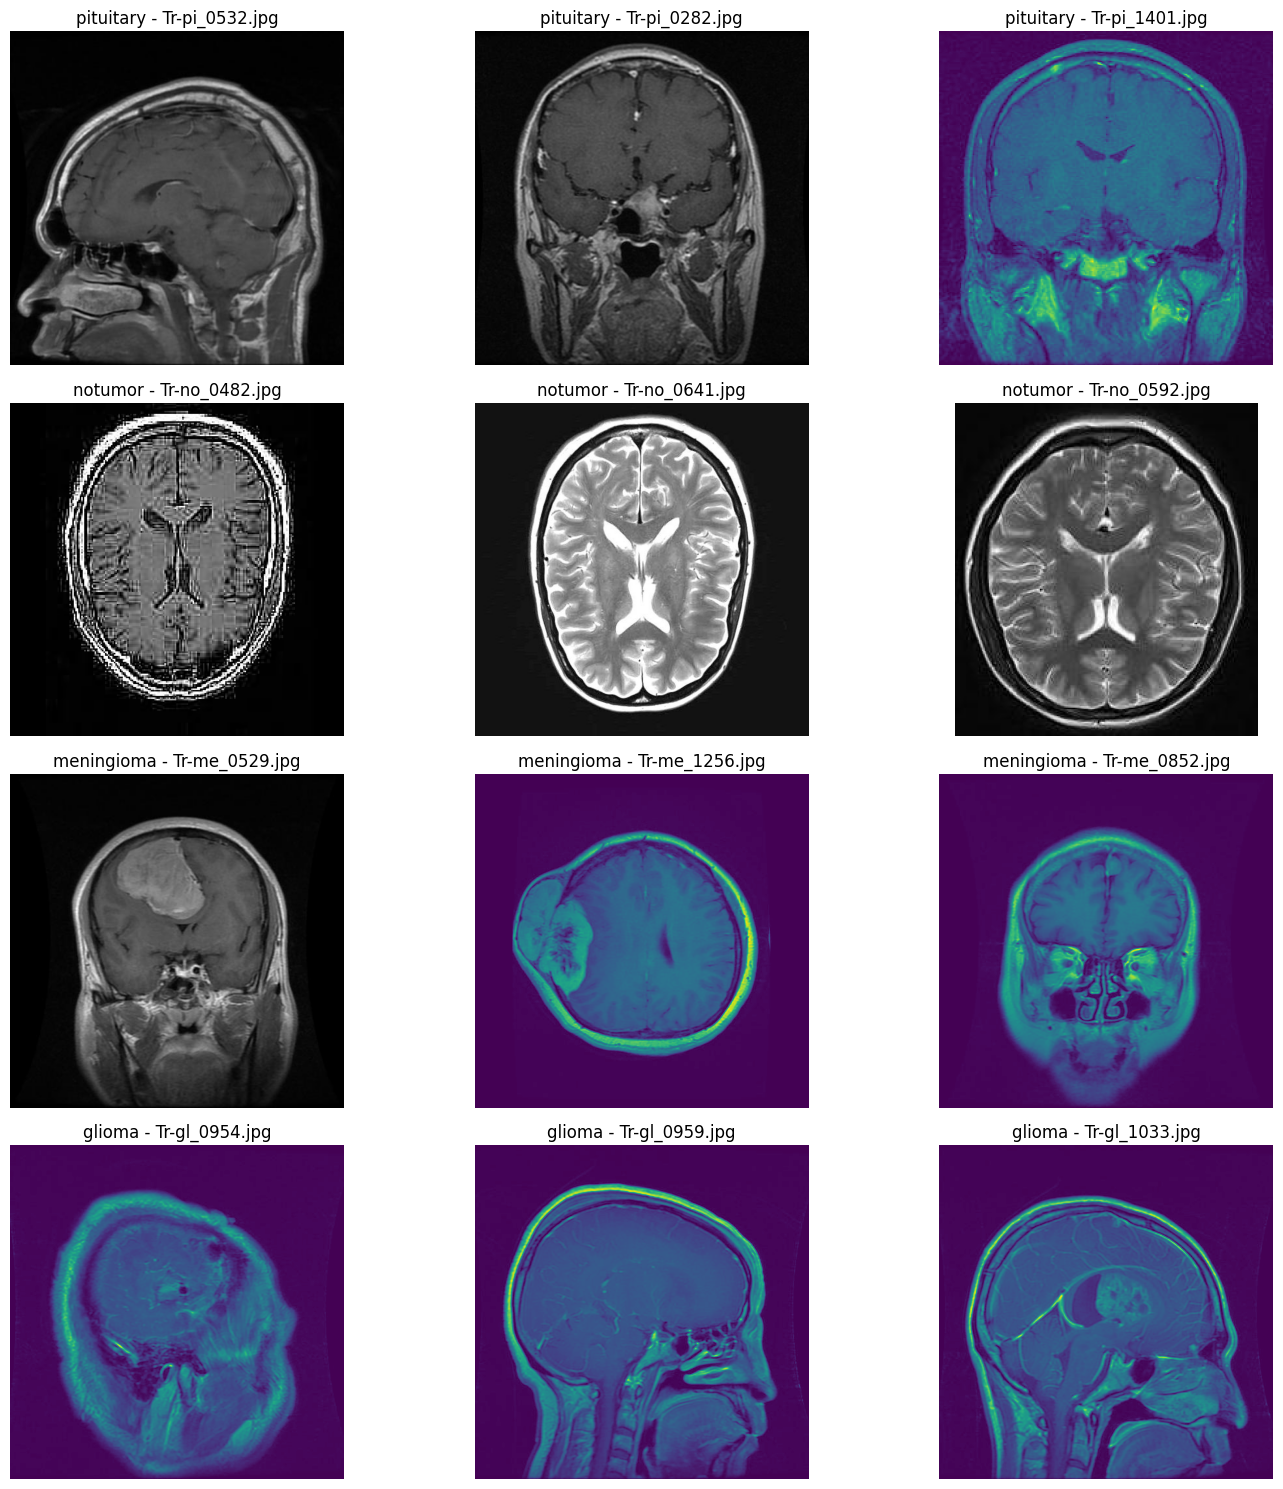

In [52]:
def plot_sample_images(directory, num_samples=3):
    plt.figure(figsize=(15, 5 * num_samples))
    class_names = os.listdir(directory)
    
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            img_files = os.listdir(class_path)[:num_samples]
            for j, img_name in enumerate(img_files):
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
                        plt.imshow(img)
                        plt.title(f"{class_name} - {img_name}")
                        plt.axis('off')
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    plt.tight_layout()
    plt.show()

plot_sample_images(train_path)

# ***CNN For Feature Extraction***

In [53]:
input_layer = Input(shape=(224, 224, 3))

# Block 1: Conv + Pooling + Dropout
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.6)(x)

# Block 2: Conv + Pooling + Dropout
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.6)(x)

# Block 3: Conv + Pooling + Dropout
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.6)(x)

# Fully Connected Layers
x = Flatten()(x)  # Flatten before Dense layer
x = Dense(32, activation='relu')(x)
output_layer = Dense(4, activation='softmax')(x)

In [54]:
# Free memory
del all_images, all_labels
gc.collect()

29749

In [55]:
cnn_model = Model(inputs=input_layer, outputs=output_layer)

In [56]:
cnn_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [57]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]


In [58]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [59]:
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=batch_size,
    callbacks=callbacks,
    class_weight=class_weight_dict

)

Epoch 1/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5094 - loss: 1.0833
Epoch 1: val_accuracy improved from -inf to 0.60969, saving model to best_model.keras
308/308 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.5098 - loss: 1.0827 - val_accuracy: 0.6097 - val_loss: 0.8466 - learning_rate: 0.0010
Epoch 2/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7842 - loss: 0.5512
Epoch 2: val_accuracy improved from 0.60969 to 0.62583, saving model to best_model.keras
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7842 - loss: 0.5511 - val_accuracy: 0.6258 - val_loss: 0.8284 - learning_rate: 0.0010
Epoch 3/50
307/308 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8310 - loss: 0.4347
Epoch 3: val_accuracy improved from 0.62583 to 0.64577, saving model to best_model.keras
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8310 - loss: 0.4346 - val_accuracy: 0.6458 - val_loss: 0.8597 - learning_rate: 0.0010
Epoch 4/50
305/308 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/

In [60]:
# Evaluate CNN
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print("CNN Test Accuracy:", test_accuracy)
y_pred_cnn = cnn_model.predict(X_test, batch_size=8)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
print("CNN Classification Report:\n", classification_report(y_test, y_pred_cnn_classes, target_names=class_names))

CNN Test Accuracy: 0.9345350861549377
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
CNN Classification Report:
               precision    recall  f1-score   support

      glioma       0.90      0.93      0.91       243
  meningioma       0.89      0.85      0.87       247
     notumor       0.99      0.97      0.98       300
   pituitary       0.94      0.97      0.96       264

    accuracy                           0.93      1054
   macro avg       0.93      0.93      0.93      1054
weighted avg       0.93      0.93      0.93      1054



In [61]:
# def augment(image, label):
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_brightness(image, max_delta=0.2)
#     image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
#     image = tf.image.random_rotation(image, angles=(-0.1, 0.1))
#     return image, label
#     train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

# # Normalize pixel values to [0, 1]
# train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))
# test_dataset = test_dataset.map(lambda x, y: (x / 255.0, y))

In [62]:
# # Normalize pixel values to [0, 1]
# train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))
# test_dataset = test_dataset.map(lambda x, y: (x / 255.0, y))

# # Apply prefetch for performance
# AUTOTUNE = tf.data.AUTOTUNE
# train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [63]:
# train_labels = np.concatenate([labels.numpy() for _, labels in train_dataset], axis=0)
# class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
# class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
# print("Class Weights:", class_weight_dict)

In [64]:
for layer in cnn_model.layers:
    print(layer.name)

input_layer_1
conv2d_3
max_pooling2d_3
dropout_3
conv2d_4
max_pooling2d_4
dropout_4
conv2d_5
max_pooling2d_5
dropout_5
flatten_1
dense_2
dense_3


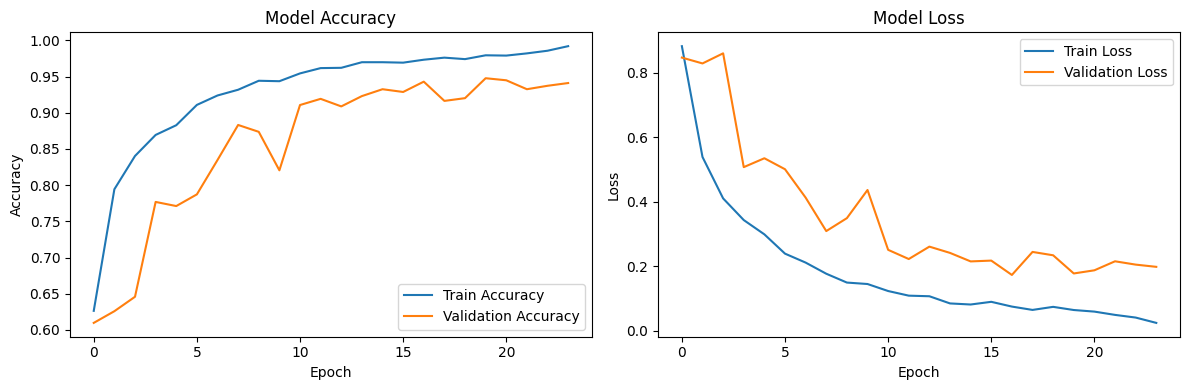

In [65]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [66]:
# Evaluate CNN on test set
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print("CNN Test Accuracy:", test_accuracy)
y_pred_cnn = cnn_model.predict(X_test, batch_size=8)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
print("CNN Classification Report:\n", classification_report(y_test, y_pred_cnn_classes, target_names=class_names))

CNN Test Accuracy: 0.9345350861549377
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
CNN Classification Report:
               precision    recall  f1-score   support

      glioma       0.90      0.93      0.91       243
  meningioma       0.89      0.85      0.87       247
     notumor       0.99      0.97      0.98       300
   pituitary       0.94      0.97      0.96       264

    accuracy                           0.93      1054
   macro avg       0.93      0.93      0.93      1054
weighted avg       0.93      0.93      0.93      1054



# ***Feature Extraction From The Flatten Layer***

In [67]:
feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-3].output)  # Extract features before last Dense

In [68]:
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)

154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [69]:
print("Extracted Feature Shape:", train_features.shape)  # (60000, num_features)

Extracted Feature Shape: (4916, 21632)


# **Feature Selection / Slight Engineering**

In [70]:
# Standardize features
scaler = StandardScaler()
X_train_features = scaler.fit_transform(train_features)
X_test_features = scaler.transform(test_features)

In [71]:
# Random Forest feature selection
rf_feature_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature_selector.fit(X_train_features, y_train)
selector = SelectFromModel(rf_feature_selector, threshold="median", prefit=True)
X_train_selected = selector.transform(X_train_features)
X_test_selected = selector.transform(X_test_features)
print(f"Random Forest Reduced Shape: {X_train_selected.shape}")

# Free memory
del train_features, test_features, X_train_features, X_test_features
gc.collect()

Random Forest Reduced Shape: (4916, 10816)


40947

In [72]:
# Feature Selection Methods
methods = {
    'Random Forest': X_train_selected,
    'Decision Trees': None,
    'Z-score': None,
    'Random Forest Gini': None
}

In [73]:
# Decision Trees Feature Selection
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train_selected, y_train)
dt_importances = dt.feature_importances_
dt_indices = np.argsort(dt_importances)[::-1][:1000]
methods['Decision Trees'] = X_train_selected[:, dt_indices]

In [74]:
# Z-score Feature Selection
z_scores = np.abs(zscore(X_train_selected, axis=0))
mean_z_scores = np.mean(z_scores, axis=0)
z_indices = np.argsort(mean_z_scores)[::-1][:1000]
methods['Z-score'] = X_train_selected[:, z_indices]

In [75]:
# Random Forest Gini Feature Selection
rf_gini = RandomForestClassifier(n_estimators=100, random_state=42)
rf_gini.fit(X_train_selected, y_train)
rf_gini_importances = rf_gini.feature_importances_
rf_gini_indices = np.argsort(rf_gini_importances)[::-1][:1000]
methods['Random Forest Gini'] = X_train_selected[:, rf_gini_indices]

In [76]:
results = {}
for method, X_train_method in methods.items():
    X_test_method = (X_test_selected[:, rf_gini_indices] if method == 'Random Forest Gini'
                     else X_test_selected[:, dt_indices] if method == 'Decision Trees'
                     else X_test_selected[:, z_indices] if method == 'Z-score'
                     else X_test_selected)
    svm = SVC(kernel='rbf', random_state=42, class_weight='balanced')
    svm.fit(X_train_method, y_train)
    y_pred = svm.predict(X_test_method)
    accuracy = accuracy_score(y_test, y_pred)
    results[method] = accuracy
    print(f"{method} SVM Accuracy: {accuracy:.4f}")

Random Forest SVM Accuracy: 0.9507
Decision Trees SVM Accuracy: 0.9336
Z-score SVM Accuracy: 0.9402
Random Forest Gini SVM Accuracy: 0.9412


In [77]:
# Plot feature selection comparison
plt.figure(figsize=(8, 4))
plt.bar(results.keys(), results.values(), color='lightgreen')
plt.title('SVM Accuracy by Feature Selection Method')
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.savefig('/kaggle/working/feature_selection_comparison.png')
plt.close()


In [78]:
# Select the best method
best_method = max(results, key=results.get)
X_train_best = methods[best_method]
X_test_best = (X_test_selected[:, rf_gini_indices] if best_method == 'Random Forest Gini'
               else X_test_selected[:, dt_indices] if best_method == 'Decision Trees'
               else X_test_selected[:, z_indices] if best_method == 'Z-score'
               else X_test_selected)

In [79]:
# Determine optimal PCA components
pca = PCA()
pca.fit(X_train_best)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 4))
plt.plot(explained_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.grid()
plt.savefig('/kaggle/working/pca_elbow.png')
plt.close()

# Choose optimal components (e.g., where variance > 95%)
optimal_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Optimal PCA components: {optimal_components}")

# Apply PCA
pca = PCA(n_components=optimal_components)
X_train_pca = pca.fit_transform(X_train_best)
X_test_pca = pca.transform(X_test_best)


Optimal PCA components: 1482


# ***Final Model***

In [ ]:
# Hyperparameter Tuning for SVM
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.001]}
grid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=3)
grid.fit(X_train_pca, y_train)
print("Best SVM Parameters:", grid.best_params_)
svm = grid.best_estimator_

# Train and evaluate final SVM
svm.fit(X_train_pca, y_train)
y_pred_final = svm.predict(X_test_pca)
final_accuracy = accuracy_score(y_test, y_pred_final)
print("Final SVM Accuracy with Best Method + PCA:", final_accuracy)
print("Final SVM Classification Report:\n", classification_report(y_test, y_pred_final, target_names=class_names))

# ***Interpretability and Explainability Methods***

In [ ]:
# AUC-ROC Curve for Final SVM
y_score = svm.decision_function(X_test_pca)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves for Final SVM')
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/multi_class_roc_curves.png')
plt.close()

In [ ]:
# Compute macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
print(f"Macro-average AUC: {roc_auc['macro']:.2f}")

In [ ]:
perm_importance = permutation_importance(svm, X_test_pca, y_test, n_repeats=10, random_state=42)
sorted_idx = np.argsort(perm_importance.importances_mean)[::-1]
print("Top 10 features by permutation importance:", sorted_idx[:10])

In [ ]:
# 2. Partial Dependence Plots (PDPs)
top_features = sorted_idx[:2]
PartialDependenceDisplay.from_estimator(svm, X_test_pca, features=top_features, feature_names=feature_names)
plt.savefig('/kaggle/working/pdp.png')
plt.close()